# ADTA 5900: CNN on CIFAR-10: Final Project

## Set Path for Data Folder

In [1]:
 # Put file path as a string here

CIFAR_DIR = 'CIFAR_10_DATA/'

## Load Data

In [2]:
# function to read files present in the Python version of the dataset

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        cifar_dict = pickle.load(fo, encoding='bytes')
    return cifar_dict

In [3]:
dirs = ['batches.meta','data_batch_1','data_batch_2','data_batch_3','data_batch_4','data_batch_5','test_batch']

all_data = [0,1,2,3,4,5,6]

for i,direc in zip(all_data,dirs):
    all_data[i] = unpickle(CIFAR_DIR+direc)

In [4]:
type(all_data)

list

In [5]:
batch_meta = all_data[0]
data_batch1 = all_data[1]
data_batch2 = all_data[2]
data_batch3 = all_data[3]
data_batch4 = all_data[4]
data_batch5 = all_data[5]
test_batch = all_data[6]

In [6]:
batch_meta

{b'num_cases_per_batch': 10000,
 b'label_names': [b'airplane',
  b'automobile',
  b'bird',
  b'cat',
  b'deer',
  b'dog',
  b'frog',
  b'horse',
  b'ship',
  b'truck'],
 b'num_vis': 3072}

In [7]:
data_batch1.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [8]:
print(len(data_batch1[b'data']))
print(len(data_batch1[b'data'][0]))

10000
3072


## Display several examples of single images using matplotlib 

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

In [10]:
X = data_batch1[b"data"] 

In [11]:
X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")

In [12]:
X[0].max()

255

In [13]:
(X[0]/255).max()

1.0

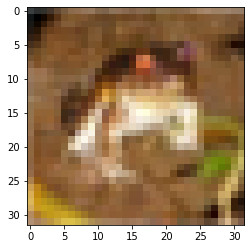

In [14]:
plt.imshow(X[0])

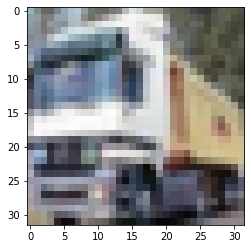

In [15]:
plt.imshow(X[1])

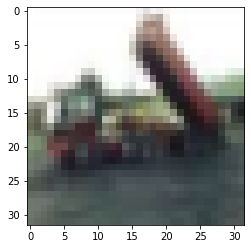

In [16]:
plt.imshow(X[2])

## Supporting Functions to Rearrange Data

### Encode Labels into One-Hot Format

In [17]:
def one_hot_encode(vec, vals=10):
    '''
    For use to one-hot encode the 10- possible labels
    '''
    n = len(vec)
    out = np.zeros((n, vals))
    out[range(n), vec] = 1
    return out

## Set Up Image Data: Make it Ready to be Fed into 1st Conv Layer

In [18]:
class CifarHelper():
    
    def __init__(self):
        self.i = 0
        
        self.all_train_batches = [data_batch1,data_batch2,data_batch3,data_batch4,data_batch5]
        self.test_batch = [test_batch]
        
        self.training_images = None
        self.training_labels = None
        
        self.test_images = None
        self.test_labels = None
    
    def set_up_images(self):
        
        print("Setting Up Training Images and Labels")
        
        self.training_images = np.vstack([d[b"data"] for d in self.all_train_batches])
        train_len = len(self.training_images)
        
        self.training_images = self.training_images.reshape(train_len,3,32,32).transpose(0,2,3,1)/255
        self.training_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.all_train_batches]), 10)
        
        print("Setting Up Test Images and Labels")
        
        self.test_images = np.vstack([d[b"data"] for d in self.test_batch])
        test_len = len(self.test_images)
        
        self.test_images = self.test_images.reshape(test_len,3,32,32).transpose(0,2,3,1)/255
        self.test_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.test_batch]), 10)

        
    def next_batch(self, batch_size):
        x = self.training_images[self.i:self.i+batch_size].reshape(100,32,32,3)
        y = self.training_labels[self.i:self.i+batch_size]
        self.i = (self.i + batch_size) % len(self.training_images)
        return x, y

## Set up image data: Calling CifarHelper.set_up_images()

In [19]:
# Before Your tf.Session run these two lines
ch = CifarHelper()
ch.set_up_images()

# During your session to grab the next batch use this line
# (Just like we did for mnist.train.next_batch)
# batch = ch.next_batch(100)

Setting Up Training Images and Labels
Setting Up Test Images and Labels


## Define Supporting Functions to Build, Train, and Test CNN Model

### Initialize Weights in Filter

In [20]:
# this function returns a tf.variable used to store weights in a filter
# this variable is initialized wth values that can be used to infiltrate weights
# the values are random numbers

def initialize_weights(filter_shape):
    init_random_dist = tf.truncated_normal(filter_shape,stddev = 0.1)
    return (tf.Variable(init_random_dist))

### Initialize bias

In [21]:
# this function returns a tf.variable used to store bias
# this variable is initialized with values that can be used to initialize bias
# the value is initialized to 0.1

def initialize_bias(bias_shape):
    initial_bias_value = tf.constant(0.1, shape=bias_shape)
    return(tf.Variable(initial_bias_value))

## set up convolution layer and perform convolution computation: dot product(x*W)

In [22]:
# define a function to set up a convolution layer (conv2d)
# parameters:
# --) inputs: [batch, H, W, Channels]
# --) filter_shape:
# [filter H, filter W, in_channels (in_depth = in_num_filters),out_channels(out_depth = out_num_filters)]
# for example: [5,5,1,32]
# Return: OUtputs of layer: the dot product: inputs*weights: x*W

def create_convolution_layer_and_compute_dot_product(inputs,filter_shape):
    
    # Initialize the weights in the filter
    filter_initialized_with_weights = initialize_weights(filter_shape)
    
    # Create a convolution layer
    conv_layer_outputs = tf.nn.conv2d(inputs,filter_initialized_with_weights, strides=[1,1,1,1],padding="SAME")
    
    # Return the convolution layer outputs
    return(conv_layer_outputs)

## Set Up a ReLU Layer and Perform Computation: Dot Product + Bias(x.W+b)

In [23]:
# define a function
# --) first, to set up a ReLU layer : an activation function layer
# --) then, perform the computaion: dot product + bias: ( x * W ) + b

# ReLU: Rectified linear unit - a popular actication function used in CNN
# in this layer, the bias has been initialized
# parameters:
# --) inputs: outputs from the preceeding convolution layer: dot product inputs*weights
# --) filter_shape:
# [filter H, filter W, in_channels (in_depth = in_num_filters),out_channels(out_depth = out_num_filters) )]
# for example: [5,5,1,32]

# Return: OUtputs of layer: the dot product+b: inputs*weights: ( x * W ) + b

def create_relu_layer_and_compute_dot_product_plus_b(inputs,filter_shape):
    
    # Initialize bias for each input channel
    b = initialize_bias ([filter_shape[3]])
    
    # perform the computatoin first by adding: inputs ( x * W ) + b
    # create a ReLU Layer associated with the preceeding convolution layer
    relu_layer_outputs = tf.nn.relu(inputs + b)
    
    # Return the relu layer outputs
    return(relu_layer_outputs)

## set up a pooling layer and reduce spatial size

In [24]:
# define a function
# --) first, to create a pooling layer
# --) then, to reduce the spatial size of the inputs data

# pooling method: Max pooling
# kernel size: 2/2
# stride: 2

# parameters:
# --) inputs: outputs of the preceding layer
# return: outputs of the layer

def create_maxpool2by2_and_reduce_spacial_size(inputs):
    
    #create a pooling layer
    pooling_layer_outputs = tf.nn.max_pool(inputs, ksize = [1,2,2,1],strides=[1,2,2,1], padding ="SAME")
    
    # return the pooling layer
    return (pooling_layer_outputs)

## set up fully connected layer and perform computation: ( inputs * weights ) + bias

In [25]:
# define a function to set up a fully connected layer
# also perform computation: (dot prodeuct (inputs * weights)) + bias
# return the results
# parametrs
# --) inputs: outputs of the preceding layer
# --) size: thge size of the outputs, i.e. number of out_channels

def create_fully_connected_layer_and_compute_dotproduct_plus_bias(inputs, output_size):
    
    # get the number of input channels from the input
    # inputs: the outputs of the preceding layer or previous operation like reshaping
    input_size = int(inputs.get_shape()[1])
    
    # initialize the weights of the filter of the FC layer
    # filter shape [in_channels, out_channels]
    # each weight for one filter cell
    W = initialize_weights([input_size, output_size])
    
    # initialize the bias: each bias one output channel
    b = initialize_bias([output_size])
    
    # --) first, perform the computation for the FC layer: Dot produt inputs + W
    # --) then, add bias to get the results: outputs of the FC layer
    fc_xW_plus_bias_outputs = tf.matmul(inputs, W) + b
    
    # return the results: outputs
    return(fc_xW_plus_bias_outputs)

# PHASE I: Build Convolutional Neural Network

In [26]:
import tensorflow as tf

## Create Placeholders for Inputs and Labels: x and y_true

In [27]:
# PLACEHOLDER

# Create a placeholder for the inputs data: x
# x: a 2D array
# x: a placeholder that can hold any number of rows/record

x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])

In [28]:
# PLACEHOLDER

# Create a placeholder for the labels of the inputs data: y_true
# y_true: a 2D array
# y_true: Can hold any number of rows/records

y_true = tf.placeholder(tf.float32, [None, 10])

## Reshape the Input Placeholder x: NOT NEED TO RESHAPE DATA HERE

In [29]:
# DO NOTHING -- DON'T NEED TO RESHAPE - DATA IS ALREADY IN GOOD SHAPE TO BE FED INTO 1ST CONVOLUTION LAYER

## Create 1st Convolution Layer and so on .............

In [30]:
# Create 1st convolutional layer, ReLu Layer, and Perform Computation: x*W + b

# Filter Shape: 5x5, input channels:1, output channels:32
# create 1st convolution layer then extract features and get the results of output that is dot product of inputs * weights
conv_layer_1_outputs \
    =create_convolution_layer_and_compute_dot_product (x, filter_shape=[5,5,3,32])

# create ReLu Layer for 1st convolution layer, accept the outputs from 1st conv as inputs
# perform computation and return the outputs of layer

conv_relu_layer_1_outputs \
    = create_relu_layer_and_compute_dot_product_plus_b(conv_layer_1_outputs, filter_shape=[5,5,3,32])

In [31]:
#create 1st pooling layer and reduce spatial size

pooling_layer_1_outputs = create_maxpool2by2_and_reduce_spacial_size(conv_relu_layer_1_outputs)

### Create 2nd Convolutional Layer, ReLu Layer and Pooling Layer

In [32]:
# Create 2nd convolutional layer

# Filter Shape: 5x5, input channels:32, output channels:64
# create 2nd convolution layer then extract features and get the results of output that is dot product of inputs * weights
conv_layer_2_outputs \
    =create_convolution_layer_and_compute_dot_product(pooling_layer_1_outputs, filter_shape=[5,5,32,64])

# return the outputs of the layer
# create ReLu Layer for 1st convolution layer, accept the outputs from 1st conv as inputs
# perform computation and return the outputs of layer

conv_relu_layer_2_outputs \
    =create_relu_layer_and_compute_dot_product_plus_b(conv_layer_2_outputs, filter_shape=[5,5,32,64])

In [33]:
# create 2nd pooling layer and reduce spatial size

pooling_layer_2_outputs = create_maxpool2by2_and_reduce_spacial_size (conv_relu_layer_2_outputs)

### reshape/flatten data making it ready to be fed into 1st FC layer

In [34]:
# reshape and flatten the output of the 2nd pooling layer
# prepare to fedd the output data into 1st fully connected layer

pooling_layer_2_outputs_flat = tf.reshape(pooling_layer_2_outputs,[-1,8*8*64])

### create 1st FC Layer, ReLU layer, and output data to dropout layer

In [35]:
# first, create the FC (fully connected) layer
# feed the output (already flattened) of the 2nd pooling layer as the inputs into this layer
# then perform the computation: dot product + bias: ( x * W ) + b

# parametrs:
#--) pooling_layer_2_outputs_flat
#--) output_size:1024 out channels

# return: outputs of the computation: ( x * W ) + b

fc_layer_1_outputs \
= create_fully_connected_layer_and_compute_dotproduct_plus_bias(pooling_layer_2_outputs_flat,output_size=1024)

# create the ReLU Layer of the 1st FC Layer
# VIP NOTES: the activation function of this layer is also ReLU

# return: outputs of the layer
fc_relu_layer_1_outputs =tf.nn.relu(fc_layer_1_outputs)

### create dropout layer and dropout a fraction of outputs randomly

In [36]:
# declare a placeholder to hold the value of probability (percentage %) to keep:
# i.e. the percentage % of total output channels that will be kept
# e.g.: keep_prob = hold_prob = 50% --> dropout 50%
# which nodes/channels to keep or dropout: selected randomly

hold_prob = tf.placeholder(tf.float32)

# dropout:
# set the outputs to 0 so that they will be ignored  in the next layer
fc_dropout_outputs = tf.nn.dropout(fc_relu_layer_1_outputs, keep_prob=hold_prob)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### create final FC Layer, compute ( x * W + b ) and produce final outputs

In [37]:
# create the final fc layer
# then compute:x * W + b
# parameters:
# --) fc_dropout_outputs: outputs from dropout layer
# --)

# return y_pred: final predicted outputs, i.e., final classification outputs

y_pred = create_fully_connected_layer_and_compute_dotproduct_plus_bias(fc_dropout_outputs,output_size=10)

### define loss function and calculate softmax cross entropy loss

In [38]:
# defiine loss function: cross-entropy with logits, i.e., with final outputs
# calculate the softmax cross-entropy loss

softmax_cross_entropy_loss = tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred)

# compute the mean of losses
cross_entropy_mean = tf.reduce_mean (softmax_cross_entropy_loss)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



### create an optimizer to optimize CNN Model and set learning rate

In [39]:
# get an Adam optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)

### create a trainer to train CNN Model

In [40]:
# create a CNN Model trainer that can train the model
# and optimize the model by minimizing the softmax cross-entropy loss

cnn_trainer = optimizer.minimize(cross_entropy_mean)

# PHASE II: Train and Test CNN Model on CIFAR-10 Dataset

### create a variable initializer to initialize all variables

In [41]:
# get a variable initializer
vars_initializer = tf.global_variables_initializer()

### set the steps

In [42]:
# x: mnist.train: 50000 images
# each time of training (run the whole process) = 1 step
# each step, i.e., each time of training: use one bacth of inputs
# batchsize = 50 images --> total number of bacthes : 50000/50 = 1000 batches

# steps: 5000: finish the training after running 5000 times

steps = 5000

### run tf.session() to train and test deep learning CNN model

In [43]:
with tf.Session() as sess:
    
    # first, run initialize all variables to initialize all variables
    sess.run(vars_initializer)
    
    for i in range(steps):
        
        # each batch : 100 images
        batch_x, batch_y = ch.next_batch(100)
        
        #train the model
        # dropout keep_prob (% to keep): 0.5 --> 50% will be dropped out
        sess.run(cnn_trainer, feed_dict={x: batch_x, y_true:batch_y, hold_prob: 0.5})
        
        # test the model: at each 100th stepo
        # run this block of code for each 100 times of training, each time run a batch
        if i % 100 == 0:
            print('ON STEP: {}'.format(i))
            print('accuracy: ')
            
            # compare to find matches of y_pred and y_true
            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))
            
            # cast the matches from integers to tf.float32
            # calculate the accuracy using the mean of matches
            acc = tf.reduce_mean(tf.cast(matches, tf.float32))
            
            # test the model at each 100th step
            # using test dataset
            # dropout: none because of test, not training
            test_accuracy = sess.run(acc,feed_dict = {x:ch.test_images,\
                                                      y_true: ch.test_labels,\
                                                     hold_prob:1.0})
            print(test_accuracy)
            print('\n')

ON STEP: 0
accuracy: 
0.132


ON STEP: 100
accuracy: 
0.3807


ON STEP: 200
accuracy: 
0.4346


ON STEP: 300
accuracy: 
0.4814


ON STEP: 400
accuracy: 
0.4976


ON STEP: 500
accuracy: 
0.5509


ON STEP: 600
accuracy: 
0.5531


ON STEP: 700
accuracy: 
0.577


ON STEP: 800
accuracy: 
0.5958


ON STEP: 900
accuracy: 
0.597


ON STEP: 1000
accuracy: 
0.6115


ON STEP: 1100
accuracy: 
0.624


ON STEP: 1200
accuracy: 
0.6094


ON STEP: 1300
accuracy: 
0.6279


ON STEP: 1400
accuracy: 
0.6331


ON STEP: 1500
accuracy: 
0.6548


ON STEP: 1600
accuracy: 
0.6479


ON STEP: 1700
accuracy: 
0.6399


ON STEP: 1800
accuracy: 
0.6439


ON STEP: 1900
accuracy: 
0.6671


ON STEP: 2000
accuracy: 
0.6496


ON STEP: 2100
accuracy: 
0.6715


ON STEP: 2200
accuracy: 
0.6682


ON STEP: 2300
accuracy: 
0.6612


ON STEP: 2400
accuracy: 
0.6689


ON STEP: 2500
accuracy: 
0.6546


ON STEP: 2600
accuracy: 
0.6741


ON STEP: 2700
accuracy: 
0.6785


ON STEP: 2800
accuracy: 
0.6603


ON STEP: 2900
accuracy: 
0.678